<a href="https://colab.research.google.com/github/ThierrryScotto/cais_maua/blob/main/cais_maua_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install --quiet pmdarima

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug  1 04:06:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Getting the data

In [5]:
url = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/datasetInterpolate.csv"

dataset = pd.read_csv(url, names=['date_time', 'mm/h', 'level_cm', 'temperature'])
dataset

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227,23.1
1,2014-07-29 13:45:00,0.0,227,23.1
2,2014-07-29 14:00:00,0.0,227,23.1
3,2014-07-29 14:15:00,0.0,225,23.1
4,2014-07-29 14:30:00,0.0,223,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260,19.0
346503,2024-06-15 23:15:00,0.0,261,19.0
346504,2024-06-15 23:30:00,0.2,261,19.0
346505,2024-06-15 23:45:00,0.0,262,19.0


In [6]:
dataset.drop(columns=["temperature", "mm/h"], inplace=True)
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


# Data Preparation

In [7]:
FIGSIZE = (20, 20)

In [8]:
def plot_dataset(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [9]:
def plot_dataset_scatter(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.scatter(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [10]:
dataset.shape

(346507, 2)

In [11]:
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


In [12]:
dataset.describe()

,level_cm
count,346507.000000
mean,167.413221
std,55.444910
min,63.000000
25%,133.000000
50%,157.000000
75%,186.000000
max,535.000000


In [13]:
dataset.isnull().sum()

,0
date_time,0
level_cm,0


In [14]:
dataset['date_time'] = pd.to_datetime(dataset['date_time'])
dataset.set_index('date_time', inplace=True)

dataset

,level_cm
date_time,
2014-07-29 13:30:00,227
2014-07-29 13:45:00,227
2014-07-29 14:00:00,227
2014-07-29 14:15:00,225
2014-07-29 14:30:00,223
...,...
2024-06-15 23:00:00,260
2024-06-15 23:15:00,261
2024-06-15 23:30:00,261


In [15]:
dataset.dtypes

,0
level_cm,int64


# Time Series EDA

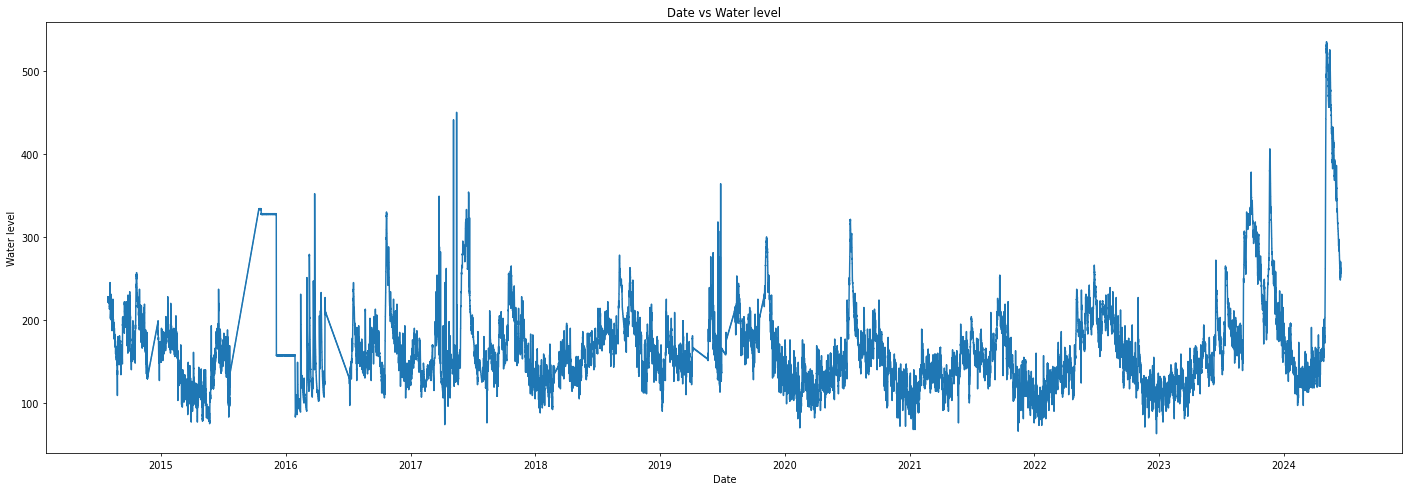

In [16]:
plot_dataset(dataset.index, dataset['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

### Selecting time

In [17]:
# Definir a faixa de datas
start_date = '2020-01-01'

# Selecionar os dados dentro da faixa de datas
df_filtered = dataset[start_date:]

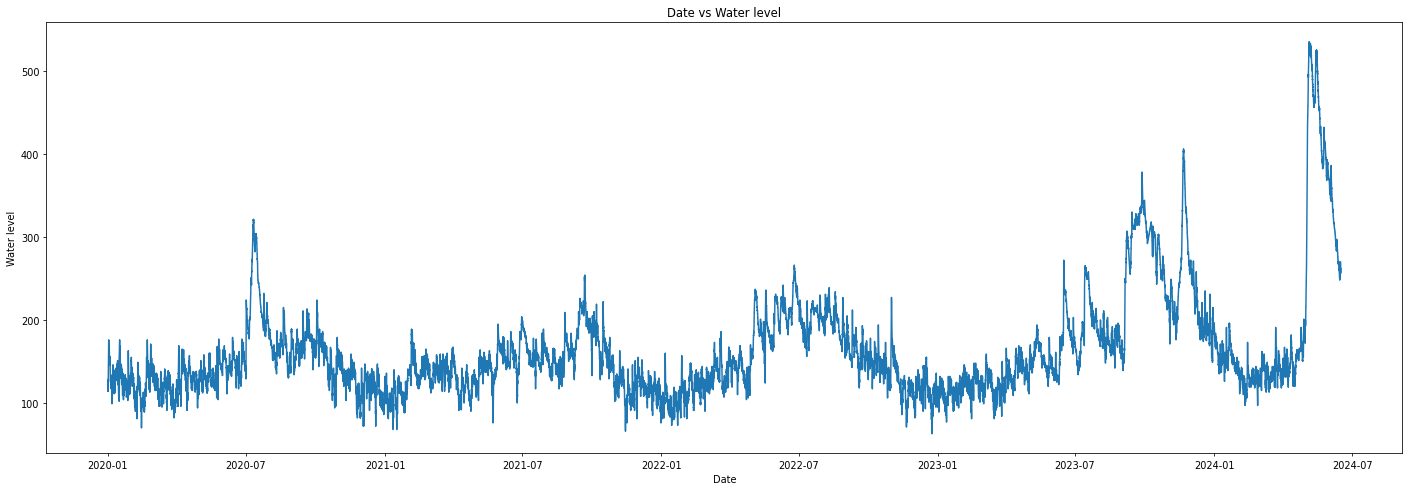

In [18]:
plot_dataset(df_filtered.index, df_filtered['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

### Grouping the data by day

In [19]:
df_daily_mean = df_filtered.resample('D').mean()
df_daily_mean

,level_cm
date_time,
2020-01-01,133.281250
2020-01-02,168.656250
2020-01-03,152.645833
2020-01-04,131.593750
2020-01-05,125.791667
...,...
2024-06-12,270.854167
2024-06-13,263.791667
2024-06-14,252.802083


## Time Series Decomposition

In [20]:
['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

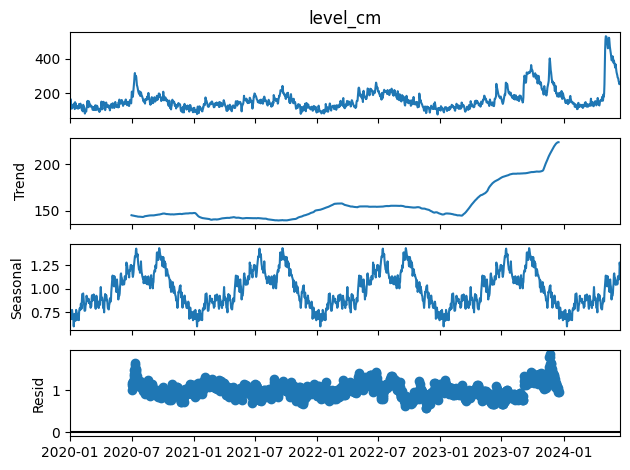

In [21]:
result = seasonal_decompose(df_daily_mean['level_cm'], model='multiplicative', period=365)
result.plot()
plt.show()

<Axes: xlabel='date_time'>

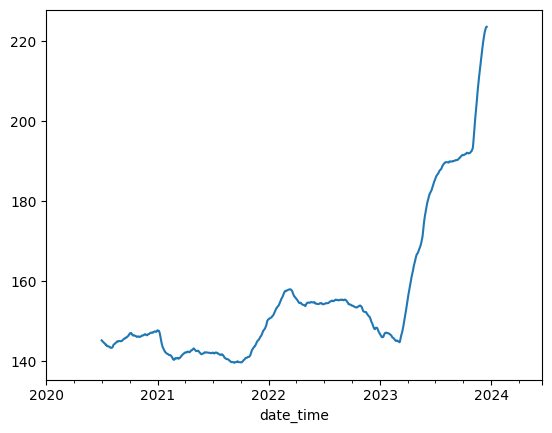

In [22]:
result.trend.plot()

<Axes: xlabel='date_time'>

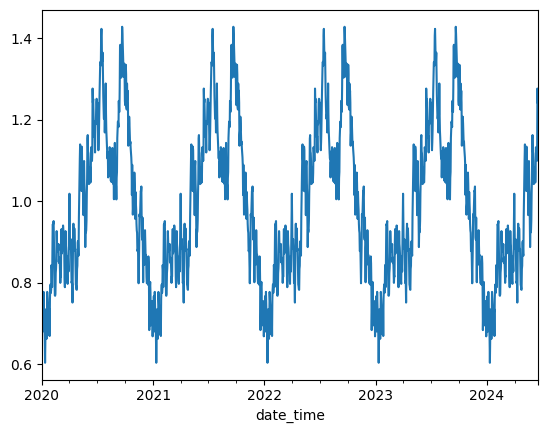

In [23]:
result.seasonal.plot()

<Axes: xlabel='date_time'>

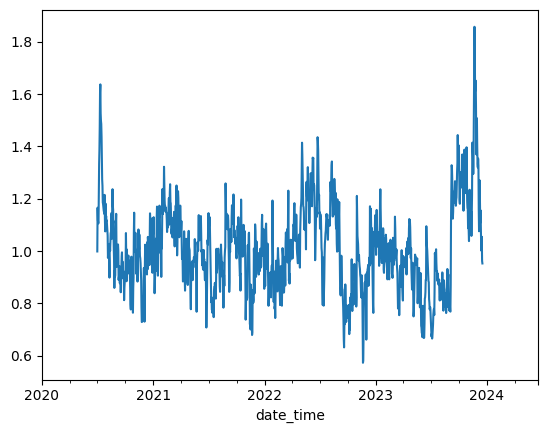

In [24]:
residual = result.resid
residual.plot()

## Making the series stationary

In [25]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")

Dickey–Fuller test

In [26]:
def check_stationarity(df):
  result = adfuller(df)

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
print('\n\n')

### Checking for stationarity

In [27]:
print("Level_cm")
check_stationarity(df_daily_mean['level_cm'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -4.273927
p-value: 0.000493
Critical values: 
	1%: -3.434378
	5%: -2.863319
	10%: -2.567717


### Transforming data

In [28]:
df_lag = pd.DataFrame()

df_lag['level_cm_lag_1'] = df_daily_mean['level_cm'] - df_daily_mean['level_cm'].shift(1)

df_lag.dropna(inplace=True)
df_lag

,level_cm_lag_1
date_time,
2020-01-02,35.375000
2020-01-03,-16.010417
2020-01-04,-21.052083
2020-01-05,-5.802083
2020-01-06,-13.593750
...,...
2024-06-12,-12.781250
2024-06-13,-7.062500
2024-06-14,-10.989583


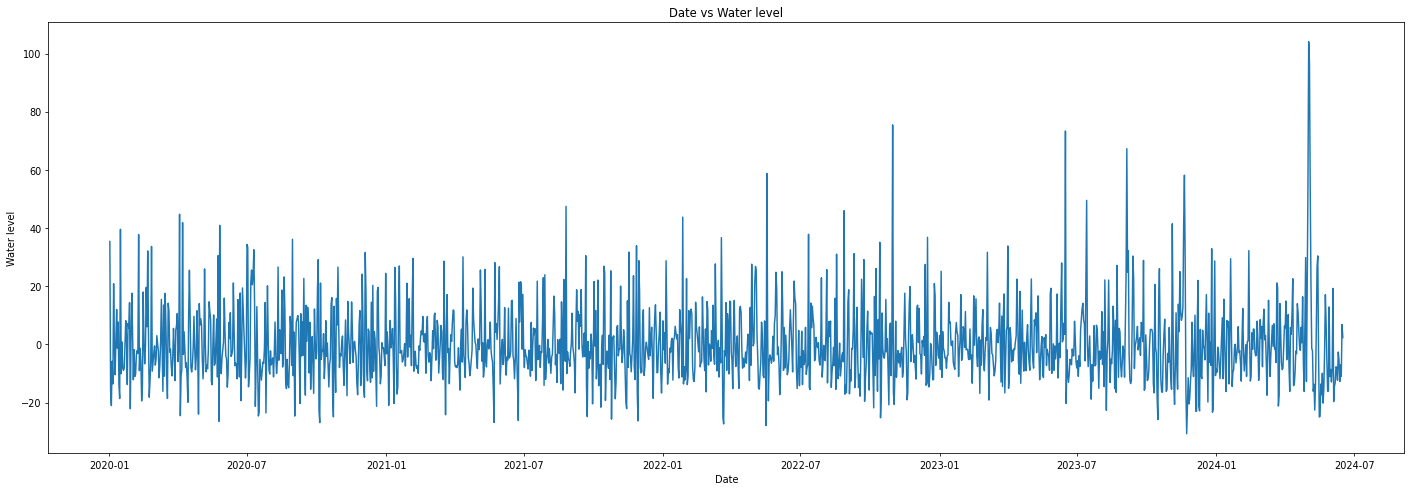

In [29]:
plot_dataset(df_lag.index, df_lag['level_cm_lag_1'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

#### Checking transformed data

In [30]:
print("Level_cm")
check_stationarity(df_lag['level_cm_lag_1'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -29.888928
p-value: 0.000000
Critical values: 
	1%: -3.434378
	5%: -2.863319
	10%: -2.567717


**Using ACF and PACF level_cm**

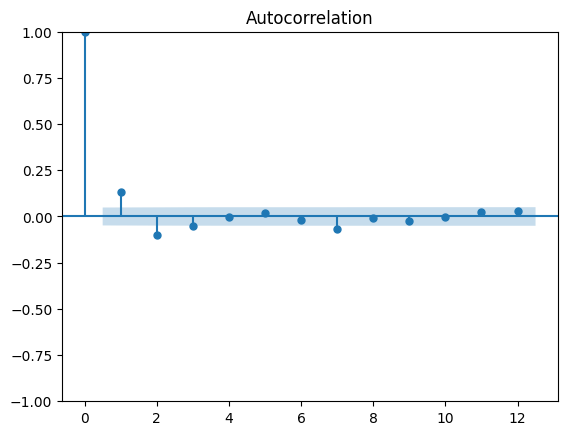

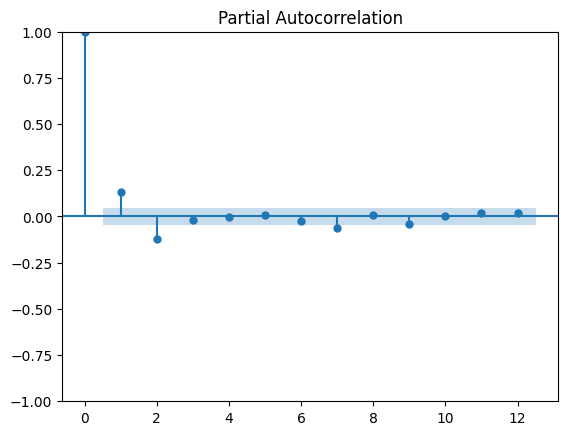

In [31]:
plot_acf(df_lag['level_cm_lag_1'], lags=12)
plot_pacf(df_lag['level_cm_lag_1'], lags=12, method="ols")
plt.show()

# Training the model

## Scaling the data

In [32]:
data = df_lag['level_cm_lag_1'].values
data

array([ 35.375     , -16.01041667, -21.05208333, ..., -10.98958333,
         6.83333333,   2.36458333])

In [33]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
# data_scaled

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_lag).flatten()
data_scaled

array([0.49033854, 0.10905859, 0.0716494 , ..., 0.14631319, 0.27855928,
       0.24540114])

In [35]:
df_scaled = pd.DataFrame()
df_scaled['level_cm_lag_1_scaled'] = data_scaled
df_scaled.index = df_lag.index
df_scaled

,level_cm_lag_1_scaled
date_time,
2020-01-02,0.490339
2020-01-03,0.109059
2020-01-04,0.071649
2020-01-05,0.184804
2020-01-06,0.126990
...,...
2024-06-12,0.133019
2024-06-13,0.175452
2024-06-14,0.146313


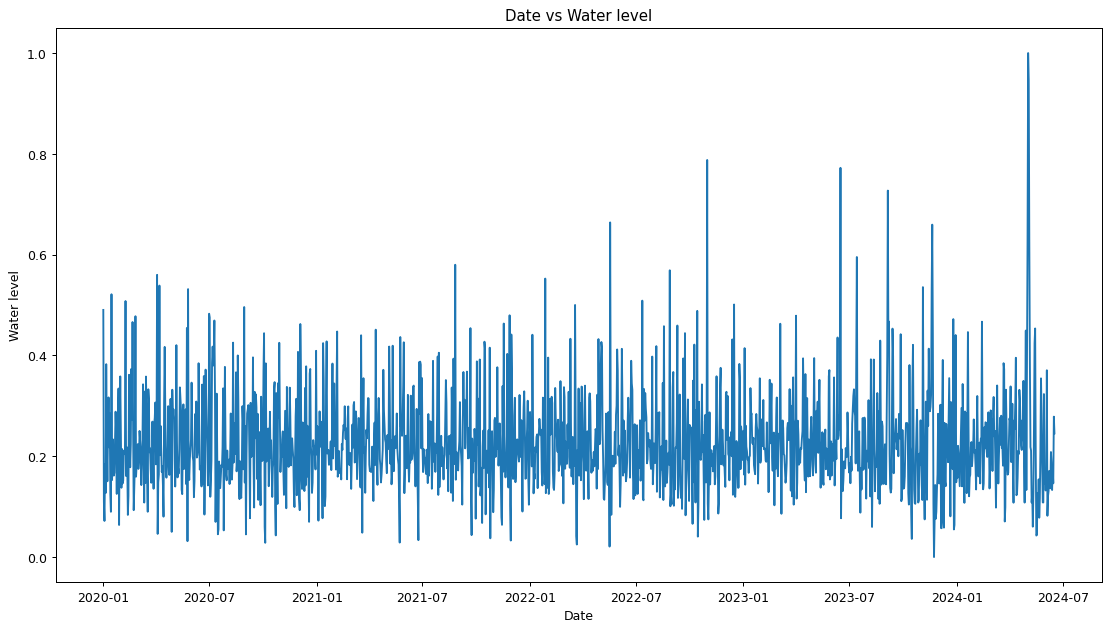

In [36]:
plot_dataset(df_scaled.index, df_scaled['level_cm_lag_1_scaled'], 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [37]:
start_date_train = '2023-01-01'

df_train = df_scaled[:start_date_train]
df_test = df_scaled[start_date_train:]

train_size = len(df_train)
test_size = len(df_test)

print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  1096
Test size:  533


In [38]:
# 67%
df_scaled.head(1091)

# 70% --> selecionado
df_scaled.head(1139)

,level_cm_lag_1_scaled
date_time,
2020-01-02,0.490339
2020-01-03,0.109059
2020-01-04,0.071649
2020-01-05,0.184804
2020-01-06,0.126990
...,...
2023-02-09,0.188978
2023-02-10,0.267197
2023-02-11,0.190679


In [39]:
df_train

,level_cm_lag_1_scaled
date_time,
2020-01-02,0.490339
2020-01-03,0.109059
2020-01-04,0.071649
2020-01-05,0.184804
2020-01-06,0.126990
...,...
2022-12-28,0.259004
2022-12-29,0.243933
2022-12-30,0.199722


In [40]:
df_test = df_test.drop(df_test.index[0])
df_test

,level_cm_lag_1_scaled
date_time,
2023-01-02,0.163627
2023-01-03,0.414515
2023-01-04,0.143685
2023-01-05,0.260550
2023-01-06,0.219045
...,...
2024-06-12,0.133019
2024-06-13,0.175452
2024-06-14,0.146313


## AUTO ARIMA

In [ ]:
# Ajustar o modelo auto_arima
model = auto_arima(df_train,
                   start_p=1,
                   start_q=1,
                   max_p=2,
                   max_q=2,
                   start_P=1,
                   start_Q=1,
                   D=0,
                   max_P=3,
                   max_D=3,
                   max_Q=3,
                   max_order=5,
                   m=365,
                   seasonal=True,
                   stepwise=True,
                   trace=True)

# Imprimir o resumo do modelo
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[365] intercept   : AIC=inf, Time=1754.89 sec
 ARIMA(0,0,0)(0,0,0)[365] intercept   : AIC=-2063.844, Time=0.14 sec


KeyboardInterrupt: 

In [ ]:
n_periods = len(df_test)  # número de períodos para prever
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast

In [ ]:
forecast.values

In [ ]:
plot_dataset(df_test.index, forecast.values, 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, df_test['level_cm_lag_1_scaled'])
plt.plot(df_test.index, forecast.values, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Undoing the scale transformation

In [ ]:
forecast = forecast.values
test_data = np.array(df_test['level_cm_lag_1_scaled'])

forecast_inversed = scaler.inverse_transform(forecast.reshape(0, 1))
test_inversed = scaler.inverse_transform(test_data.reshape(0, 1))

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, test_inversed)
plt.plot(df_test.index, forecast_inversed, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Calculating error

In [ ]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
print("MSE: ", mean_squared_error(test_inversed, forecast_inversed))

In [ ]:
print("RMSE: ", root_mean_squared_error(test_inversed, forecast_inversed))

##LSTM

Converting test and training to numpy arrays

In [41]:
df_train_array = np.array(df_train.values)
df_test_array = np.array(df_test.values)

In [42]:
df_train_array

array([[0.49033854],
       [0.10905859],
       [0.0716494 ],
       ...,
       [0.19972175],
       [0.19268821],
       [0.2504251 ]])

Creating the entry set, mini-batches

In [43]:
def create_dataset(dataset, look_back=1):
    x, y = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        x.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(x), np.array(y)

In [44]:
look_back = 1
train_x, train_y = create_dataset(df_train.values, look_back)
test_x, test_y = create_dataset(df_test.values, look_back)

In [45]:
print("    X            Y")
for i in range(5):
    print(train_x[i], train_y[i], "\n")

    X            Y
[0.49033854] 0.10905858710774492 

[0.10905859] 0.07164940485391885 

[0.0716494] 0.18480445200185522 

[0.18480445] 0.1269902612459424 

[0.12699026] 0.3826712011130005 



[samples, time steps, features]

In [46]:
np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1])).shape

(1094, 1, 1)

In [47]:
# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Definindo o modelo
model = Sequential()

# Adicionando a camada LSTM com função de ativação tanh
model.add(LSTM(4, activation='tanh', input_shape=(1, look_back)))

# Adicionando a camada Dropout para regularização
model.add(Dropout(0.2))

# Adicionando a camada de saída com função de ativação tanh
model.add(Dense(1, activation='tanh'))

# Compilando o modelo com função de perda e otimizador
model.compile(loss='mean_squared_error', optimizer='adam')

# Treinando o modelo
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1094/1094 - 6s - 5ms/step - loss: 0.0132
Epoch 2/100
1094/1094 - 3s - 3ms/step - loss: 0.0092
Epoch 3/100
1094/1094 - 3s - 3ms/step - loss: 0.0090
Epoch 4/100
1094/1094 - 3s - 2ms/step - loss: 0.0090
Epoch 5/100
1094/1094 - 3s - 2ms/step - loss: 0.0089
Epoch 6/100
1094/1094 - 3s - 2ms/step - loss: 0.0090
Epoch 7/100
1094/1094 - 3s - 2ms/step - loss: 0.0089
Epoch 8/100
1094/1094 - 3s - 2ms/step - loss: 0.0090
Epoch 9/100
1094/1094 - 3s - 2ms/step - loss: 0.0089
Epoch 10/100
1094/1094 - 3s - 3ms/step - loss: 0.0089
Epoch 11/100
1094/1094 - 3s - 2ms/step - loss: 0.0089
Epoch 12/100
1094/1094 - 3s - 3ms/step - loss: 0.0089
Epoch 13/100
1094/1094 - 3s - 2ms/step - loss: 0.0089
Epoch 14/100
1094/1094 - 3s - 2ms/step - loss: 0.0089
Epoch 15/100
1094/1094 - 3s - 2ms/step - loss: 0.0089
Epoch 16/100
1094/1094 - 3s - 2ms/step - loss: 0.0089
Epoch 17/100
1094/1094 - 3s - 3ms/step - loss: 0.0089
Epoch 18/100
1094/1094 - 3s - 2ms/step - loss: 0.0089
Epoch 19/100
1094/1094 - 3s - 2ms/ste

make predictions

In [49]:
# make predictions
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


invert predictions

In [50]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
train_y_normal = scaler.inverse_transform([train_y])

test_predict = scaler.inverse_transform(test_predict)
test_y_normal = scaler.inverse_transform([test_y])

calculate root mean squared error

In [51]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(train_y_normal[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(test_y_normal[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.67 RMSE
Test Score: 14.66 RMSE


In [52]:
len(test_y_normal[0])

530

In [53]:
index = np.arange(0, len(test_y_normal[0]))

In [54]:
print("predicted size", len(test_predict))
print("Test size: ", len(test_y_normal[0]))

predicted size 530
Test size:  530


Text(0.5, 1.0, 'Forecast using ARIMA - Test')

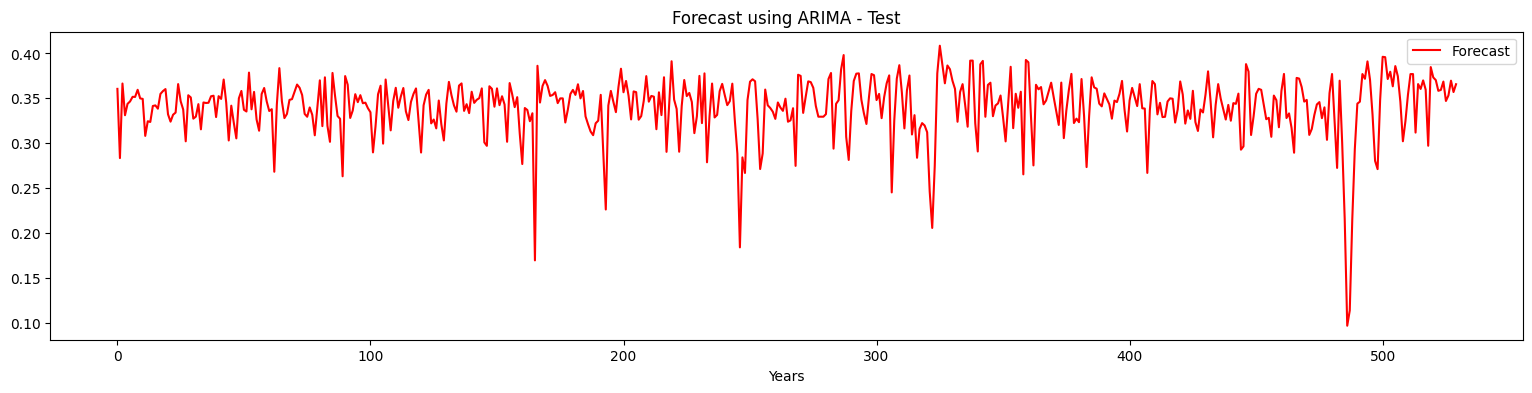

In [57]:
plt.figure(figsize=(19, 4))
#plt.plot(index, test_y_normal[0])
plt.plot(index, test_predict, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

Dados deslocados

In [56]:
# trainPredictPlot = np.empty_like(dataset)
# # trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# # shift test predictions for plotting
# testPredictPlot = np.empty_like(dataset)
# # testPredictPlot[:, :] = np.nan
# testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

###Inverse transform